<a href="https://colab.research.google.com/github/aknakshay/Face-Recognition-From-Scratch/blob/master/1FaceNet_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FaceNet Implementation

#### Misc : Copying Transformed Data from Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!cp /content/drive/My\ Drive/Colab\ Notebooks/CapstoneProject/Algined-Data/transformedData-IMFDB.zip .
!unzip -q transformedData-IMFDB.zip
!mv /content/content/* /content

### Face Aligner Class: Aligns the faces by applying affine transformations

In [10]:
import numpy as np
import cv2
!pip install mtcnn

### https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/

class FaceAligner:
    def __init__(self, predictor, desiredLeftEye=(0.35, 0.35),
        desiredFaceWidth=224, desiredFaceHeight=224):
        # store the facial landmark predictor, desired output left
        # eye position, and desired output face width + height
        self.predictor = predictor
        self.desiredLeftEye = desiredLeftEye
        self.desiredFaceWidth = desiredFaceWidth
        self.desiredFaceHeight = desiredFaceHeight

        # if the desired face height is None, set it to be the
        # desired face width (normal behavior)
        if self.desiredFaceHeight is None:
            self.desiredFaceHeight = self.desiredFaceWidth

    def align(self, image, keypoints):
        # convert the landmark (x, y)-coordinates to a NumPy array
        #shape = self.predictor(gray, rect)
        #shape = shape_to_np(shape)

        # extract the left and right eye (x, y)-coordinates
        #(lStart, lEnd) = FACIAL_LANDMARKS_IDXS["left_eye"]
        #(rStart, rEnd) = FACIAL_LANDMARKS_IDXS["right_eye"]
        #leftEyePts = shape[lStart:lEnd]
        #rightEyePts = shape[rStart:rEnd]

        # compute the center of mass for each eye
        #leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
        #rightEyeCenter = rightEyePts.mean(axis=0).astype("int")
        leftEyeCenter = keypoints['left_eye']
        rightEyeCenter = keypoints['right_eye']

        # compute the angle between the eye centroids
        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]
        angle = np.degrees(np.arctan2(dY, dX)) #- 180

        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
        desiredDist *= self.desiredFaceWidth
        scale = desiredDist / dist

        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
            (leftEyeCenter[1] + rightEyeCenter[1]) // 2)

        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])

        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
            (leftEyeCenter[1] + rightEyeCenter[1]) // 2)
 
        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
 
        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])
        
        # apply the affine transformation
        (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
        output = cv2.warpAffine(image, M, (w, h),
            flags=cv2.INTER_CUBIC)
 
        # return the aligned face
        return output

     |████████████████████████████████| 2.3MB 2.8MB/s 
  Created wheel for mtcnn: filename=mtcnn-0.0.9-cp36-none-any.whl size=2257690 sha256=d1d4633f0a8eb97eebafead1c211479811eb816367078da9bbb0c0fa9d713bea
  Stored in directory: /root/.cache/pip/wheels/85/81/65/6363fa5aafd7a155c896591e0c7c6e27b69642aa82b9cbf076
Successfully built mtcnn


### Importing Required Libraries

In [0]:
import os
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
from mtcnn.mtcnn import MTCNN
import random

In [12]:
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D,AveragePooling2D
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D, concatenate
from keras import models
from keras.models import Model, Sequential
import tensorflow as tf
from keras.utils import np_utils
from keras import regularizers
from keras.layers import Lambda
import keras.backend as K

Using TensorFlow backend.


### 1. Load Image DataSet

In [0]:
!wget http://cvit.iiit.ac.in/projects/IMFDB/IMFDB_final.zip -O /content/IMFDB_final.zip
!unzip -q IMFDB_final.zip

#### Function to process data and load the locations of files in a list. If transformed data is present in given directory, it just adds the location in the files

In [0]:

def preProcessLoad(imagePath,detector,faceAligner):
  image = cv2.imread(imagePath)
  rects = detector.detect_faces(image)
  if len(rects) == 1  :
    faceAligned = faceAligner.align(image, rects[0]['keypoints'])
    return 1,faceAligned
  else:
    return 0,image


def load_dataset(basePath,transformedPath):
  images = []
  if os.path.exists(transformedPath):
    names = os.listdir(transformedPath)
    for name in names:
       movies = os.listdir(os.path.join(transformedPath,name))
       for movie in movies:
        if os.path.exists(os.path.join(transformedPath,name,movie,'images')):
          dirImages = os.listdir(os.path.join(transformedPath,name,movie,'images'))
          dirImagesPaths = [os.path.join(transformedPath,name,movie,'images',image) for image in dirImages]
          images += dirImagesPaths
    return images
  else:
    filtered = 0
    count = 0
    name_count = 0 
    detector = MTCNN()
    fa = FaceAligner(detector, desiredFaceWidth=224)
    names = os.listdir(basePath)
    names.remove('.DS_Store')
    for name in names:
        movies = os.listdir(os.path.join(basePath,name))
        name_count += 1
        for movie in movies:   
            if os.path.exists(os.path.join(basePath,name,movie,'images')):
                dirImages = os.listdir(os.path.join(basePath,name,movie,'images'))
                dirImagesPaths = [os.path.join(name,movie,'images',image) for image in dirImages] 
                os.system("mkdir -p " + os.path.join(transformedPath,name,movie,'images'))
                for img_path in dirImagesPaths:
                  status, faceAligned = preProcessLoad(os.path.join(basePath,img_path),detector,fa)
                  if status == 1:
                    cv2.imwrite(os.path.join(transformedPath,img_path),faceAligned)
                    images.append(os.path.join(transformedPath,img_path))
                    count += 1
                  else:
                    filtered += 1
            clear_output(wait=True)
            print("Processed " + str(count) + " images. ---- Percentage Done: " + str(100 * name_count/len(names))[:5] + "%")
    del fa
    del detector
    print("Number of Images Filtered Out: " + str(filtered))
    return images


In [0]:
#Loading the Data 
basePath = "/content/IMFDB_final"
transformedPath = "/content/IMFDB_final_transformed"
images = load_dataset(basePath,transformedPath)

#### Sample Flow of Face Detection, Image Alignment and Resize

Input Image: 


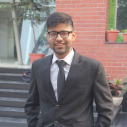

Processed Image:


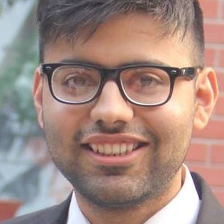

In [17]:
detector = MTCNN()
fa = FaceAligner(detector, desiredFaceWidth=224)


def preProcess(imagePath):
  image = cv2.imread(imagePath)
  rects = detector.detect_faces(image)
  if len(rects) == 1  :
    faceAligned = fa.align(image, rects[0]['keypoints'])
    return 1,faceAligned
  else:
    return 0,image

def get_alignment(imgPath):
  img = cv2.imread(imgPath) 
  print("Input Image: ")
  scale=10
  cv2_imshow(cv2.resize(img, (int(scale*img.shape[1]/100),int(scale*img.shape[0]/100)), interpolation = cv2.INTER_AREA))
  status,processed = preProcess(imgPath)
  if status==1:
    print("Processed Image:")
    cv2_imshow(processed)
    return processed
  else:
    print("Image should have one face")
    return 0

processed = get_alignment('/content/12402037_804755383002939_2785894861387070956_o (1).jpg')
del detector
del fa


#### Loading the location and label of image in a dataframe

In [0]:
dataset = pd.DataFrame([images]).transpose()
dataset.columns=['location']
dataset = dataset.join(dataset['location'].str.split('/',expand =True))
dataset['label'] = dataset.loc[:,3]
dataset.drop(columns=[0,1,2,3,4,5,6],inplace=True)
dataset.columns=['location','label']

#### Checking the dimension of images and doing quantile analysis on it. It would show 224*224 in all if data is processed using pre processing steps

In [0]:
def shape(x):
  s = cv2.imread(x).shape
  return s[0]*s[1]
dataset['imgsize'] = dataset['location'].apply(shape)

In [20]:
q = dataset['imgsize'].quantile(np.arange(0,1.1,0.1))
import math
c = 0 
print("Qnt: Dimensions")
for i in list(q):
  s = str(int(math.sqrt(i)))
  print(str(c) + "  :  " + s + " X " + s)
  c += 1

Qnt: Dimensions
0  :  224 X 224
1  :  224 X 224
2  :  224 X 224
3  :  224 X 224
4  :  224 X 224
5  :  224 X 224
6  :  224 X 224
7  :  224 X 224
8  :  224 X 224
9  :  224 X 224
10  :  224 X 224


#### Encoding Labels from strings to integers

In [0]:
lb_make = LabelEncoder()
dataset["label"] = lb_make.fit_transform(dataset["label"])

In [22]:
dataset.head()

,location,label,imgsize
0,/content/IMFDB_final_transformed/Venkatesh/Jay...,97,50176
1,/content/IMFDB_final_transformed/Venkatesh/Jay...,97,50176
2,/content/IMFDB_final_transformed/Venkatesh/Jay...,97,50176
3,/content/IMFDB_final_transformed/Venkatesh/Jay...,97,50176
4,/content/IMFDB_final_transformed/Venkatesh/Jay...,97,50176


#### Removing images having lesser pixels : Required if dataset preprocessing is not done. Right now, images are of the size 224 X 224 = 50176


In [0]:
dataset = dataset[dataset.imgsize > 10000]
dataset.reset_index(inplace=True)

#### Separating out last n identities 

In [0]:
names = list(dataset.label.unique())
no_identitites_test = 10
cut = names[len(names)-no_identitites_test]

In [0]:
cut_index = dataset[dataset['label'] == cut].index[0]

In [0]:
df_train = dataset[:cut_index]
df_validation = dataset[cut_index:]

#### Filtering out identities having less than 10 images

In [32]:
print("Total Images for Training Before Filtration: " + str(len(df_train)))
for i in df_train.label.unique():
  tmp = df_train[df_train.label == i]
  if len(tmp) < 10:
    df_train = df_train.drop(tmp.index,axis=0)
print("Total Images for Training After Filtration: " + str(len(df_train)))

Total Images for Training Before Filtration: 9859
Total Images for Training After Filtration: 9850


### 2. PreProcess Image

1.   Detect Face in the image using MTCNN and crop the image accordingly
2.   Normalize the image
3.   Resize the image to the input size of 224 × 224


#### Processing

In [0]:
'''
Uncomment the below two lines if one the go Face Detection and Alignment is required.
Also uncomment preprocessing_function=preProcess in ImageDataGenerator initialisers

Have done the preprocessing on the entire dataset since on the fly process consumes a lot of memory
and epoch time increases multifold. Moreover, even in 'on the fly' process the same images
would be transformed into the same output which will be redundant. Hence, decided to do it offline.
'''


#detector = MTCNN()
#fa = FaceAligner(detector, desiredFaceWidth=224)

def preProcessGen(image):
  rects = detector.detect_faces(image)
  if len(rects) >= 1  :
    faceAligned = fa.align(image, rects[0]['keypoints'])
    return faceAligned
  else:
    return image


datagen_train = ImageDataGenerator(
    samplewise_center= True,
    samplewise_std_normalization=True,
    horizontal_flip=True
   )#, preprocessing_function=preProcessGen)

datagen_val = ImageDataGenerator(
    samplewise_center= True,
    samplewise_std_normalization=True
    )#, preprocessing_function=preProcessGen),







Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.



In [0]:
batch_size = 100
img_dimension = (224,224)

train_generator = datagen_train.flow_from_dataframe(df_train, x_col='location', y_col='label', target_size=img_dimension, color_mode='rgb', class_mode='raw', 
                    batch_size=batch_size, shuffle=True, interpolation='nearest', validate_filenames=True)

validation_generator = datagen_val.flow_from_dataframe(df_validation, x_col='location', y_col='label', target_size=img_dimension, color_mode='rgb', class_mode='raw', 
                    batch_size=batch_size, shuffle=False, seed=0, interpolation='nearest', validate_filenames=True)

Found 9850 validated image filenames.
Found 1230 validated image filenames.


### 3. Training (with online Triplet Mining)

For each minibatch in data:
1. Train the network forward and store the 128-D embedding
2. Calculate the distance between each of the image in the mini batch
3. From an anchor, find semi hard and hard positives and negatives amongst the minibatch for each identity with alpha (margin) set to 0.01
3. Using armax of positive and armgmin of negative, get the triplet to be used to calculate loss
3. Back Propogate the feedback w.r.t loss

#### Functions to calculate triplet loss

In [0]:
# https://github.com/omoindrot/tensorflow-triplet-loss/blob/master/model/triplet_loss.py

"""Define functions to create the triplet loss with online triplet mining."""

import tensorflow as tf


def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.

    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.

    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]

    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.

    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]

    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.

    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]

    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask


def batch_all_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.

    We generate all the valid triplets and average the loss over the positive ones.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
  #  assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
   # assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, fraction_positive_triplets


def batch_hard_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.

    For each anchor, we get the hardest positive and hardest negative to form a triplet.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    labels = tf.squeeze(labels, axis=-1)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss

#### Lambda Layer - L2 Normalisation

In [0]:
def l2_norm2d(x, pool_size = (3,3), strides = (1,1), padding = 'same'):
    x = x ** 2
    output = AveragePooling2D(pool_size, strides, padding)(x)
    output  = K.sqrt(output)
    return output

#### Model Architecture - NN2 Model

In [0]:
def NN2_Model():
  inputs = Input(shape=(224,224,3))

  conv1 = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
  conv1 = MaxPooling2D(pool_size=(3,3), strides=(2, 2),padding='same')(conv1)
  conv1 = BatchNormalization()(conv1)

  inception2 = Conv2D(64,(1,1),padding='same')(conv1)
  inception2 = Conv2D(192,(3,3),padding='same')(inception2)
  inception2 = BatchNormalization()(inception2)
  inception2 = MaxPooling2D(pool_size=(3,3), strides=(2, 2),padding='same')(inception2)
  inception2 = BatchNormalization()(inception2)


  inception3a_a = Conv2D(64,(1,1),padding='same')(inception2)
  inception3a_b = Conv2D(96,(1,1),padding='same')(inception2)
  inception3a_b = Conv2D(128,(3,3),padding='same')(inception3a_b)
  inception3a_c = Conv2D(16,(1,1),padding='same')(inception2)
  inception3a_c = Conv2D(32,(5,5),padding='same')(inception3a_c)
  inception3a_d = MaxPooling2D((3,3),padding='same', strides=(1, 1))(inception2)
  inception3a_d = Conv2D(32,(1,1),padding='same')(inception3a_d)

  inception3a = concatenate([inception3a_a,inception3a_b,inception3a_c,inception3a_d])


  inception3b_a = Conv2D(64,(1,1),padding='same')(inception3a)
  inception3b_b = Conv2D(96,(1,1),padding='same')(inception3a)
  inception3b_b = Conv2D(128,(3,3),padding='same')(inception3b_b)
  inception3b_c = Conv2D(32,(1,1),padding='same')(inception3a)
  inception3b_c = Conv2D(64,(5,5),padding='same')(inception3b_c)
  inception3b_d = Lambda(l2_norm2d)(inception3a)
  inception3b_d = Conv2D(64,(1,1),padding='same')(inception3b_d)

  inception3b = concatenate([inception3b_a,inception3b_b,inception3b_c,inception3b_d])



  inception3c_b = Conv2D(128,(1,1),padding='same')(inception3b)
  inception3c_b = Conv2D(256,(3,3),padding='same')(inception3c_b)
  inception3c_b = MaxPooling2D((3,3),padding='same', strides=(2, 2))(inception3c_b) 

  inception3c1_b = Conv2D(128,(1,1),padding='same')(inception3b)
  inception3c1_b = Conv2D(256,(3,3),padding='same')(inception3c1_b)
  inception3c1_b = MaxPooling2D((3,3),padding='same', strides=(2, 2))(inception3c1_b) 

  inception3c_c = Conv2D(32,(1,1),padding='same')(inception3b)
  inception3c_c = Conv2D(64,(5,5),padding='same')(inception3c_c)
  inception3c_c = MaxPooling2D((3,3),padding='same', strides=(2, 2))(inception3c_c) 

  inception3c1_c = Conv2D(32,(1,1),padding='same')(inception3b)
  inception3c1_c = Conv2D(64,(5,5),padding='same')(inception3c1_c)
  inception3c1_c = MaxPooling2D((3,3),padding='same', strides=(2, 2))(inception3c1_c) 

  inception3c = concatenate([inception3c_b,inception3c1_b,inception3c_c,inception3c1_c])
  inception3c = BatchNormalization()(inception3c)

  inception4a_a = Conv2D(256,(1,1),padding='same')(inception3c)
  inception4a_b = Conv2D(96,(1,1),padding='same')(inception3c)
  inception4a_b = Conv2D(192,(3,3),padding='same')(inception4a_b)
  inception4a_c = Conv2D(32,(1,1),padding='same')(inception3c)
  inception4a_c = Conv2D(64,(5,5),padding='same')(inception4a_c)
  inception4a_d = Lambda(l2_norm2d)(inception3c)
  inception4a_d = Conv2D(128,(1,1),padding='same')(inception4a_d)

  inception4a = concatenate([inception4a_a,inception4a_b,inception4a_c,inception4a_d])



  inception4b_a = Conv2D(224,(1,1),padding='same')(inception4a)
  inception4b_b = Conv2D(112,(1,1),padding='same')(inception4a)
  inception4b_b = Conv2D(224,(3,3),padding='same')(inception4b_b)
  inception4b_c = Conv2D(32,(1,1),padding='same')(inception4a)
  inception4b_c = Conv2D(64,(5,5),padding='same')(inception4b_c)
  inception4b_d = Lambda(l2_norm2d)(inception4a)
  inception4b_d = Conv2D(128,(1,1),padding='same')(inception4b_d)

  inception4b = concatenate([inception4b_a,inception4b_b,inception4b_c,inception4b_d])


  inception4c_a = Conv2D(192,(1,1),padding='same')(inception4b)
  inception4c_b = Conv2D(128,(1,1),padding='same')(inception4b)
  inception4c_b = Conv2D(256,(3,3),padding='same')(inception4c_b)
  inception4c_c = Conv2D(32,(1,1),padding='same')(inception4b)
  inception4c_c = Conv2D(64,(5,5),padding='same')(inception4c_c)
  inception4c_d = Lambda(l2_norm2d)(inception4b)
  inception4c_d = Conv2D(128,(1,1),padding='same')(inception4c_d)

  inception4c = concatenate([inception4c_a,inception4c_b,inception4c_c,inception4c_d])


  inception4d_a = Conv2D(160,(1,1),padding='same')(inception4c)
  inception4d_b = Conv2D(144,(1,1),padding='same')(inception4c)
  inception4d_b = Conv2D(288,(3,3),padding='same')(inception4d_b)
  inception4d_c = Conv2D(32,(1,1),padding='same')(inception4c)
  inception4d_c = Conv2D(64,(5,5),padding='same')(inception4d_c)
  inception4d_d = Lambda(l2_norm2d)(inception4c)
  inception4d_d = Conv2D(128,(1,1),padding='same')(inception4d_d)

  inception4d = concatenate([inception4d_a,inception4d_b,inception4d_c,inception4d_d])


  inception4e_b = Conv2D(160,(1,1),padding='same')(inception4d)
  inception4e_b = Conv2D(256,(3,3),padding='same')(inception4e_b)
  inception4e_b = MaxPooling2D((3,3),padding='same', strides=(2, 2))(inception4e_b) 

  inception4e1_b = Conv2D(160,(1,1),padding='same')(inception4d)
  inception4e1_b = Conv2D(256,(3,3),padding='same')(inception4e1_b)
  inception4e1_b = MaxPooling2D((3,3),padding='same', strides=(2, 2))(inception4e1_b) 

  inception4e_c = Conv2D(64,(1,1),padding='same')(inception4d)
  inception4e_c = Conv2D(128,(5,5),padding='same')(inception4e_c)
  inception4e_c = MaxPooling2D((3,3),padding='same', strides=(2, 2))(inception4e_c) 

  inception4e1_c = Conv2D(64,(1,1),padding='same')(inception4d)
  inception4e1_c = Conv2D(128,(5,5),padding='same')(inception4e1_c)
  inception4e1_c = MaxPooling2D((3,3),padding='same', strides=(2, 2))(inception4e1_c) 

  inception4e = concatenate([inception4e_b,inception4e1_b,inception4e_c,inception4e1_c])
  inception4e = BatchNormalization()(inception4e)

  inception5a_a = Conv2D(384,(1,1),padding='same')(inception4e)
  inception5a_b = Conv2D(192,(1,1),padding='same')(inception4e)
  inception5a_b = Conv2D(384,(3,3),padding='same')(inception5a_b)
  inception5a_c = Conv2D(48,(1,1),padding='same')(inception4e)
  inception5a_c = Conv2D(128,(5,5),padding='same')(inception5a_c)
  inception5a_d = Lambda(l2_norm2d)(inception4e)
  inception5a_d = Conv2D(128,(1,1),padding='same')(inception5a_d)

  inception5a = concatenate([inception5a_a,inception5a_b,inception5a_c,inception5a_d])

  inception5b_a = Conv2D(192,(1,1),padding='same')(inception5a)
  inception5b_b = Conv2D(128,(1,1),padding='same')(inception5a)
  inception5b_b = Conv2D(256,(3,3),padding='same')(inception5b_b)
  inception5b_c = Conv2D(32,(1,1),padding='same')(inception5a)
  inception5b_c = Conv2D(64,(5,5),padding='same')(inception5b_c)
  inception5b_d = MaxPooling2D((3,3),padding='same', strides=(1, 1))(inception5a)
  inception5b_d = Conv2D(128,(1,1),padding='same')(inception5b_d)

  inception5b = concatenate([inception5b_a,inception5b_b,inception5b_c,inception5b_d])
  inception5b = BatchNormalization()(inception5b)

  avgpool = AveragePooling2D(pool_size=(7, 7))(inception5b)
  avgpool = Flatten()(avgpool)

  outputs = Dense(128,kernel_regularizer=regularizers.l2(0.01))(avgpool)

  model = Model(input=inputs,output=outputs)

  return model

#### Metric: Fraction of Positive Triplets

In [0]:
# Derived from https://github.com/omoindrot/tensorflow-triplet-loss/blob/master/model/triplet_loss.py

def fraction_positive_triplets(labels, embeddings, margin=0.1, squared=False):
      # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
  #  assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
   # assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    return fraction_positive_triplets

#### Training Model

In [0]:
# Initializing the model

model = NN2_Model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 56, 56, 64)   0           conv2d_68[0][0]                  
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 56, 56, 64)   256         max_pooling2d_13[0][0]           
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:147: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [0]:
# Triplet Loss Functions

def loss_func_batch_hard(y_true, y_pred): 
    return batch_hard_triplet_loss(y_true, y_pred,margin=2)

def loss_func_batch_all(y_true, y_pred): 
    loss, fraction_positive = batch_all_triplet_loss(y_true, y_pred, margin=1e-4, squared=False)
    return loss

# Optimizer
opt = Adam(lr=1e-4, beta_1=0.7, beta_2=0.8, amsgrad=False)

# Compiling the model
model.compile(optimizer=opt, loss=loss_func_batch_hard, metrics=[fraction_positive_triplets])


In [0]:
history = model.fit_generator(
        train_generator,
        epochs=50,
        validation_data=validation_generator)

Epoch 1/50
99/99 [==============================] - 136s 1s/step - loss: 4.0942 - fraction_positive_triplets: 0.5811 - val_loss: 4.7933 - val_fraction_positive_triplets: 0.5230
Epoch 2/50
99/99 [==============================] - 121s 1s/step - loss: 3.6578 - fraction_positive_triplets: 0.5981 - val_loss: 4.3822 - val_fraction_positive_triplets: 0.5295
Epoch 3/50
99/99 [==============================] - 122s 1s/step - loss: 3.3740 - fraction_positive_triplets: 0.6052 - val_loss: 4.0693 - val_fraction_positive_triplets: 0.5435
Epoch 4/50
99/99 [==============================] - 121s 1s/step - loss: 3.0891 - fraction_positive_triplets: 0.6081 - val_loss: 3.7706 - val_fraction_positive_triplets: 0.5497
Epoch 5/50
99/99 [==============================] - 121s 1s/step - loss: 2.8764 - fraction_positive_triplets: 0.6095 - val_loss: 3.5737 - val_fraction_positive_triplets: 0.5654
Epoch 6/50
99/99 [==============================] - 121s 1s/step - loss: 2.6820 - fraction_positive_triplets: 0.609

#### Training Loss vs Validation Loss

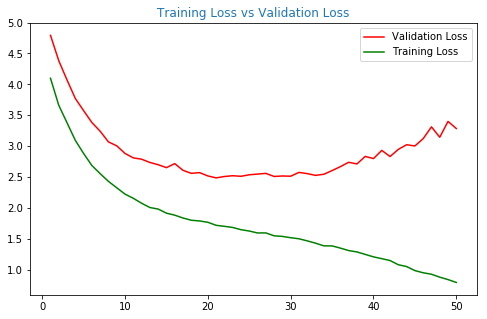

In [0]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Training Loss vs Validation Loss', color='C0')
ax.plot(range(1,len(history.history['val_loss'])+1),history.history['val_loss'],  label='Validation Loss',color='red')
ax.plot(range(1,len(history.history['loss'])+1),history.history['loss'],  label='Training Loss',color='green')

ax.legend()

#### Plotting & Saving Model

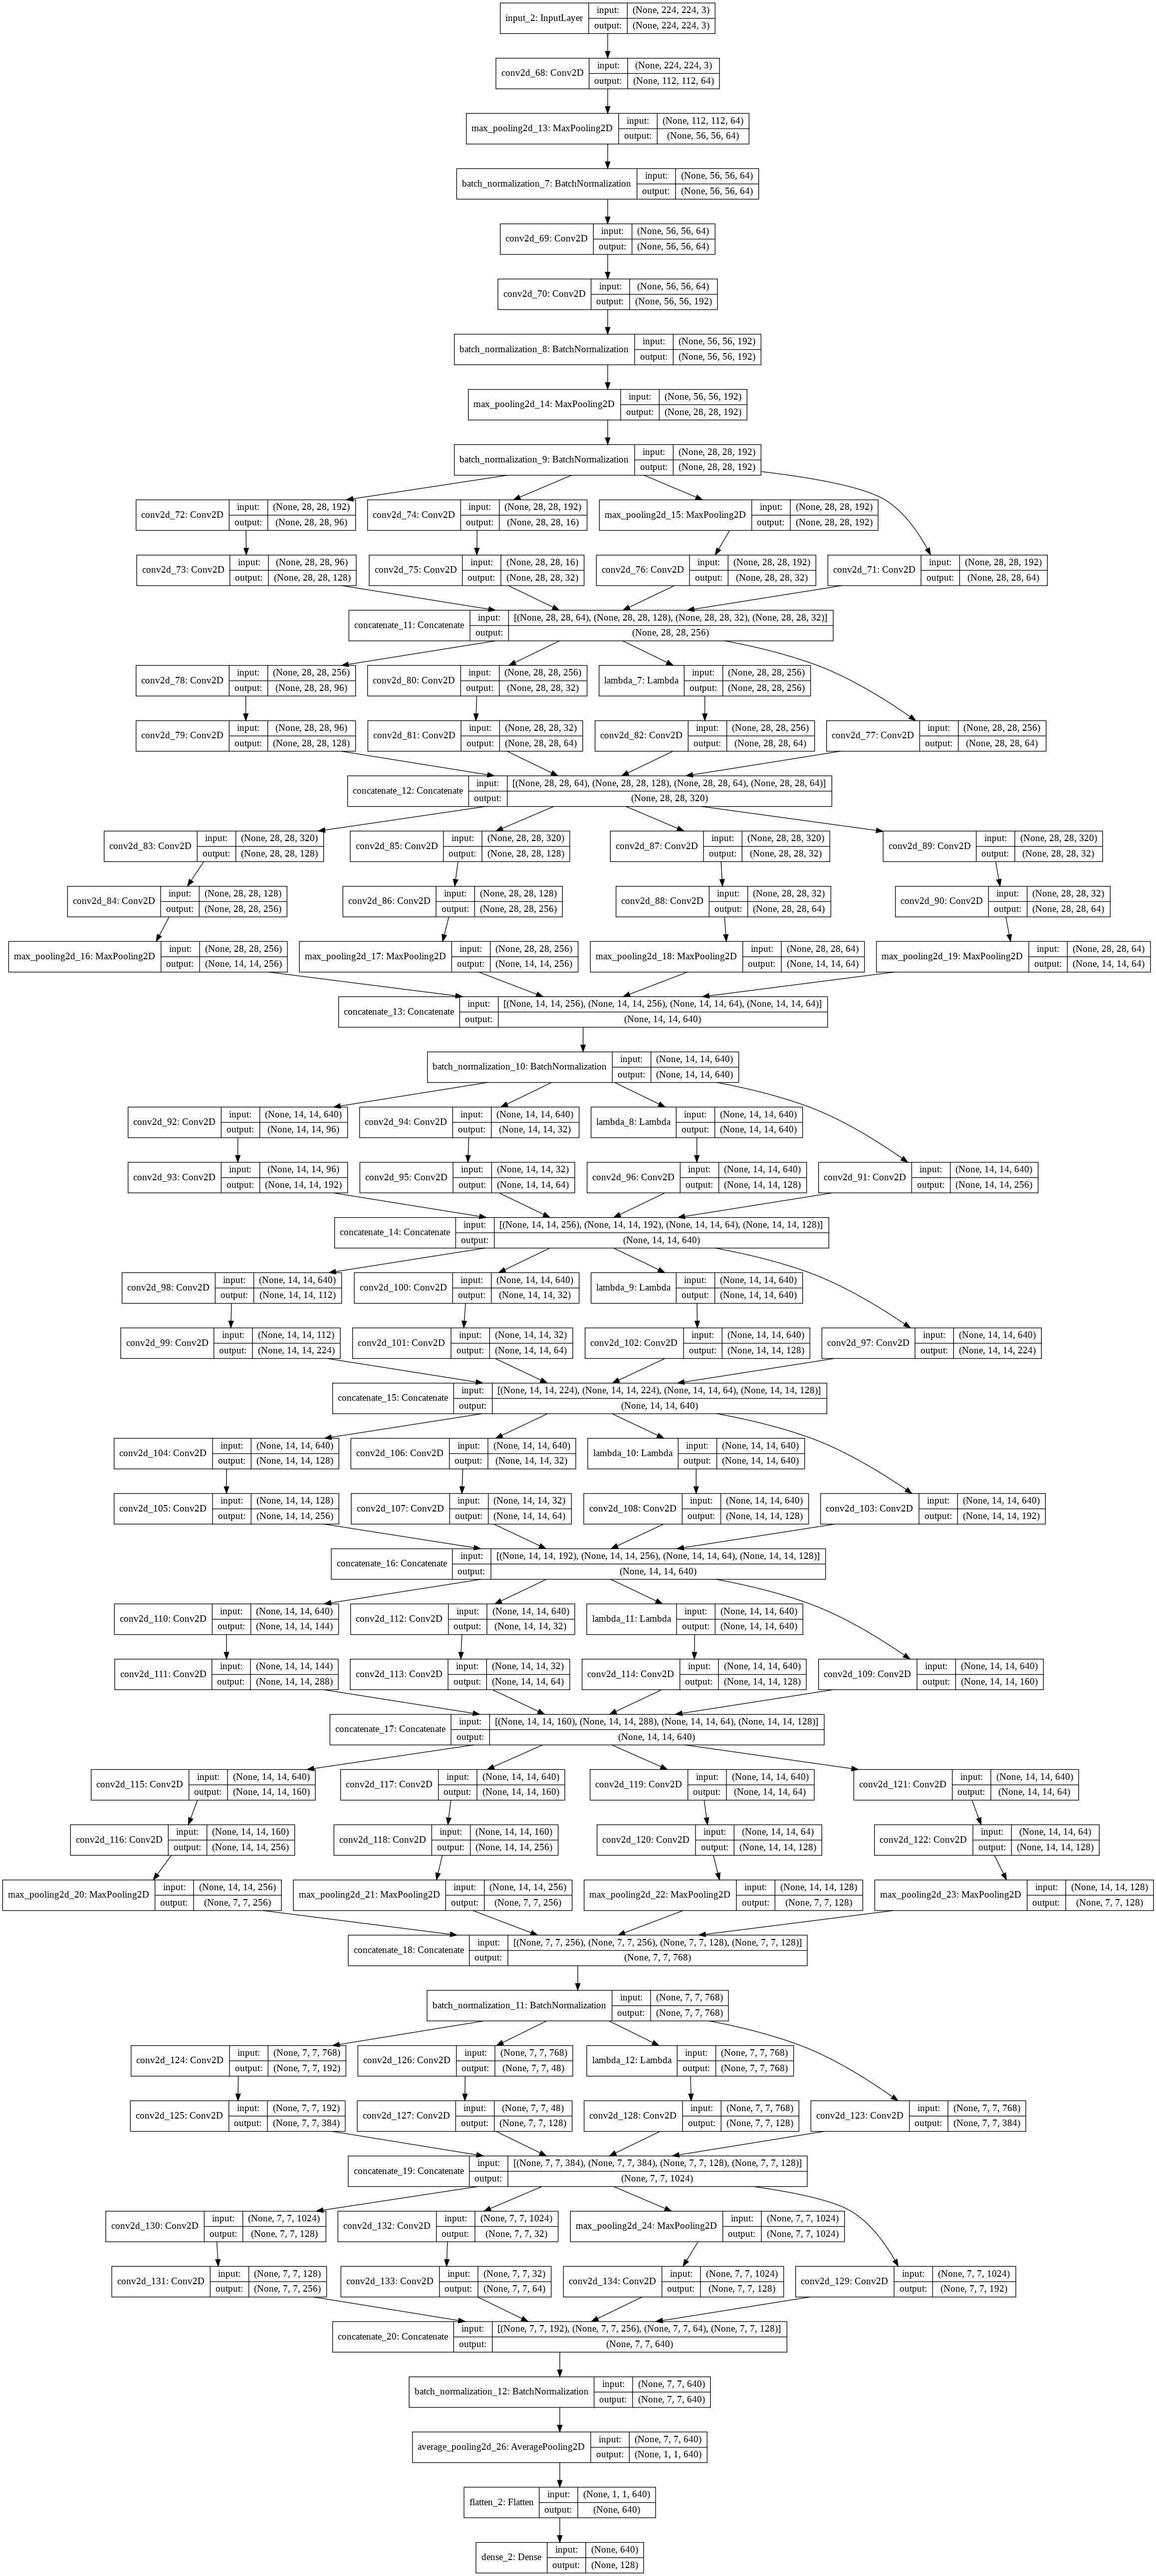

In [0]:
plot_model(model,to_file="modelPlot.png",show_shapes=True,show_layer_names=True)

In [0]:
model.save("model30.h5",model,include_optimizer=True)

In [0]:
from keras.models import load_model
from keras import backend 

# Triplet Loss Functions

def loss_func_batch_hard(y_true, y_pred): 
    return batch_hard_triplet_loss(y_true, y_pred,margin=2)

def loss_func_batch_all(y_true, y_pred): 
    loss, fraction_positive = batch_all_triplet_loss(y_true, y_pred, margin=1e-4, squared=False)
    return loss


modelPredictor = load_model("model30.h5",custom_objects={
    "backend": backend,
    "AveragePooling2D": AveragePooling2D,
    "loss_func_batch_hard": loss_func_batch_hard,
    "fraction_positive_triplets": fraction_positive_triplets
})  


#### Visualising Embeddings

13/13 [==============================] - 6s 487ms/step


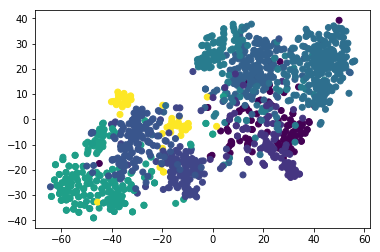

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE()
X_test_trm = model.predict_generator(validation_generator, steps=len(validation_generator), verbose=1)
eval_tsne_embeds = tsne.fit_transform(X_test_trm)
plt.scatter(eval_tsne_embeds[:,0],eval_tsne_embeds[:,1],c=df_validation.label)

In [0]:
pred = model.predict_generator(validation_generator, steps=len(validation_generator), verbose=1)
np.savetxt("embeddings-30",pred,delimiter='\t')
np.savetxt("embeddings.meta-30",df_validation.label)

labels_txt = lb_make.inverse_transform(df_validation.label)
with open("embeddings-names.txt","w+") as f:
  for entry in labels_txt:
    f.write(entry + "\n")

13/13 [==============================] - 5s 353ms/step


### SVM : Face Recognition

SVM is trained over validation data of 1230 images

80% of these images are used for training 

20% of these images are used for testing

In [0]:
datagen_test = ImageDataGenerator(
    samplewise_center= True,
    samplewise_std_normalization=True
    )#, preprocessing_function=myFunc),


In [0]:
test_generator = datagen_test.flow_from_dataframe(df_validation, x_col='location', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='raw', 
                    batch_size=100, shuffle=False, seed=0, interpolation='nearest', validate_filenames=True)

Found 1230 validated image filenames.


In [0]:
test_embeddings = modelPredictor.predict_generator(test_generator, steps=len(test_generator), verbose=1)

13/13 [==============================] - 5s 356ms/step


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(test_embeddings,df_validation['label'], test_size=0.20, random_state=42)

In [0]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train) 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)
print("Accuracy is " + str(accuracy_score(y_test, y_pred)*100)[:5] + "%")

Accuracy is 82.52%


In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           2       0.56      0.56      0.56        18
          16       0.73      0.79      0.76        14
          21       0.79      1.00      0.88        19
          26       0.86      0.97      0.91        32
          30       0.73      0.91      0.81        33
          35       0.93      0.93      0.93        43
          40       0.71      0.43      0.54        23
          52       0.86      0.67      0.75        18
          53       0.97      0.94      0.96        34
          93       1.00      0.67      0.80        12

    accuracy                           0.83       246
   macro avg       0.81      0.79      0.79       246
weighted avg       0.83      0.83      0.82       246



### tf.contrib.loss Implementation : 

Implemented a work around to make it work

In [0]:
# Copyright 2017 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Implements various metric learning losses."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import sparse_tensor
from tensorflow.python.framework import tensor_shape
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import logging_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from tensorflow.python.ops import script_ops
from tensorflow.python.ops import sparse_ops
from tensorflow.python.summary import summary
try:
  # pylint: disable=g-import-not-at-top
  from sklearn import metrics
  HAS_SKLEARN = True
except ImportError:
  HAS_SKLEARN = False


def pairwise_distance(feature, squared=False):
  """Computes the pairwise distance matrix with numerical stability.

  output[i, j] = || feature[i, :] - feature[j, :] ||_2

  Args:
    feature: 2-D Tensor of size [number of data, feature dimension].
    squared: Boolean, whether or not to square the pairwise distances.

  Returns:
    pairwise_distances: 2-D Tensor of size [number of data, number of data].
  """
  pairwise_distances_squared = math_ops.add(
      math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
      math_ops.reduce_sum(
          math_ops.square(array_ops.transpose(feature)),
          axis=[0],
          keepdims=True)) - 2.0 * math_ops.matmul(feature,
                                                  array_ops.transpose(feature))

  # Deal with numerical inaccuracies. Set small negatives to zero.
  pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
  # Get the mask where the zero distances are at.
  error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

  # Optionally take the sqrt.
  if squared:
    pairwise_distances = pairwise_distances_squared
  else:
    pairwise_distances = math_ops.sqrt(
        pairwise_distances_squared +
        math_ops.cast(error_mask, dtypes.float32) * 1e-16)

  # Undo conditionally adding 1e-16.
  pairwise_distances = math_ops.multiply(
      pairwise_distances,
      math_ops.cast(math_ops.logical_not(error_mask), dtypes.float32))

  num_data = array_ops.shape(feature)[0]
  # Explicitly set diagonals to zero.
  mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
      array_ops.ones([num_data]))
  pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
  return pairwise_distances


def contrastive_loss(labels, embeddings_anchor, embeddings_positive,
                     margin=1.0):
  """Computes the contrastive loss.

  This loss encourages the embedding to be close to each other for
    the samples of the same label and the embedding to be far apart at least
    by the margin constant for the samples of different labels.
  See: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf

  Args:
    labels: 1-D tf.int32 `Tensor` with shape [batch_size] of
      binary labels indicating positive vs negative pair.
    embeddings_anchor: 2-D float `Tensor` of embedding vectors for the anchor
      images. Embeddings should be l2 normalized.
    embeddings_positive: 2-D float `Tensor` of embedding vectors for the
      positive images. Embeddings should be l2 normalized.
    margin: margin term in the loss definition.

  Returns:
    contrastive_loss: tf.float32 scalar.
  """
  # Get per pair distances
  distances = math_ops.sqrt(
      math_ops.reduce_sum(
          math_ops.squared_difference(embeddings_anchor, embeddings_positive),
          1))

  # Add contrastive loss for the siamese network.
  #   label here is {0,1} for neg, pos.
  return math_ops.reduce_mean(
      math_ops.cast(labels, dtypes.float32) * math_ops.square(distances) +
      (1. - math_ops.cast(labels, dtypes.float32)) *
      math_ops.square(math_ops.maximum(margin - distances, 0.)),
      name='contrastive_loss')


def masked_maximum(data, mask, dim=1):
  """Computes the axis wise maximum over chosen elements.

  Args:
    data: 2-D float `Tensor` of size [n, m].
    mask: 2-D Boolean `Tensor` of size [n, m].
    dim: The dimension over which to compute the maximum.

  Returns:
    masked_maximums: N-D `Tensor`.
      The maximized dimension is of size 1 after the operation.
  """
  axis_minimums = math_ops.reduce_min(data, dim, keepdims=True)
  masked_maximums = math_ops.reduce_max(
      math_ops.multiply(data - axis_minimums, mask), dim,
      keepdims=True) + axis_minimums
  return masked_maximums


def masked_minimum(data, mask, dim=1):
  """Computes the axis wise minimum over chosen elements.

  Args:
    data: 2-D float `Tensor` of size [n, m].
    mask: 2-D Boolean `Tensor` of size [n, m].
    dim: The dimension over which to compute the minimum.

  Returns:
    masked_minimums: N-D `Tensor`.
      The minimized dimension is of size 1 after the operation.
  """
  axis_maximums = math_ops.reduce_max(data, dim, keepdims=True)
  masked_minimums = math_ops.reduce_min(
      math_ops.multiply(data - axis_maximums, mask), dim,
      keepdims=True) + axis_maximums
  return masked_minimums


def triplet_semihard_loss(labels, embeddings, margin=0.01):
  """Computes the triplet loss with semi-hard negative mining.

  The loss encourages the positive distances (between a pair of embeddings with
  the same labels) to be smaller than the minimum negative distance among
  which are at least greater than the positive distance plus the margin constant
  (called semi-hard negative) in the mini-batch. If no such negative exists,
  uses the largest negative distance instead.
  See: https://arxiv.org/abs/1503.03832.

  Args:
    labels: 1-D tf.int32 `Tensor` with shape [batch_size] of
      multiclass integer labels.
    embeddings: 2-D float `Tensor` of embedding vectors. Embeddings should
      be l2 normalized.
    margin: Float, margin term in the loss definition.

  Returns:
    triplet_loss: tf.float32 scalar.
  """
  # Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
  lshape = array_ops.shape(labels)
  #assert lshape.shape == 1
  labels = array_ops.reshape(labels, [lshape[0], 1])

  # Build pairwise squared distance matrix.
  pdist_matrix = pairwise_distance(embeddings, squared=True)
  # Build pairwise binary adjacency matrix.
  adjacency = math_ops.equal(labels, array_ops.transpose(labels))
  # Invert so we can select negatives only.
  adjacency_not = math_ops.logical_not(adjacency)

  batch_size = array_ops.size(labels)

  # Compute the mask.
  pdist_matrix_tile = array_ops.tile(pdist_matrix, [batch_size, 1])
  mask = math_ops.logical_and(
      array_ops.tile(adjacency_not, [batch_size, 1]),
      math_ops.greater(
          pdist_matrix_tile, array_ops.reshape(
              array_ops.transpose(pdist_matrix), [-1, 1])))
  mask_final = array_ops.reshape(
      math_ops.greater(
          math_ops.reduce_sum(
              math_ops.cast(mask, dtype=dtypes.float32), 1, keepdims=True),
          0.0), [batch_size, batch_size])
  mask_final = array_ops.transpose(mask_final)

  adjacency_not = math_ops.cast(adjacency_not, dtype=dtypes.float32)
  mask = math_ops.cast(mask, dtype=dtypes.float32)

  # negatives_outside: smallest D_an where D_an > D_ap.
  negatives_outside = array_ops.reshape(
      masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size])
  negatives_outside = array_ops.transpose(negatives_outside)

  # negatives_inside: largest D_an.
  negatives_inside = array_ops.tile(
      masked_maximum(pdist_matrix, adjacency_not), [1, batch_size])
  semi_hard_negatives = array_ops.where(
      mask_final, negatives_outside, negatives_inside)

  loss_mat = math_ops.add(margin, pdist_matrix - semi_hard_negatives)

  mask_positives = math_ops.cast(
      adjacency, dtype=dtypes.float32) - array_ops.diag(
          array_ops.ones([batch_size]))

  # In lifted-struct, the authors multiply 0.5 for upper triangular
  #   in semihard, they take all positive pairs except the diagonal.
  num_positives = math_ops.reduce_sum(mask_positives)

  triplet_loss = math_ops.truediv(
      math_ops.reduce_sum(
          math_ops.maximum(
              math_ops.multiply(loss_mat, mask_positives), 0.0)),
      num_positives,
      name='triplet_semihard_loss')

  return triplet_loss


# pylint: disable=line-too-long
def npairs_loss(labels, embeddings_anchor, embeddings_positive,
                reg_lambda=0.002, print_losses=False):
  """Computes the npairs loss.

  Npairs loss expects paired data where a pair is composed of samples from the
  same labels and each pairs in the minibatch have different labels. The loss
  has two components. The first component is the L2 regularizer on the
  embedding vectors. The second component is the sum of cross entropy loss
  which takes each row of the pair-wise similarity matrix as logits and
  the remapped one-hot labels as labels.

  See: http://www.nec-labs.com/uploads/images/Department-Images/MediaAnalytics/papers/nips16_npairmetriclearning.pdf

  Args:
    labels: 1-D tf.int32 `Tensor` of shape [batch_size/2].
    embeddings_anchor: 2-D Tensor of shape [batch_size/2, embedding_dim] for the
      embedding vectors for the anchor images. Embeddings should not be
      l2 normalized.
    embeddings_positive: 2-D Tensor of shape [batch_size/2, embedding_dim] for the
      embedding vectors for the positive images. Embeddings should not be
      l2 normalized.
    reg_lambda: Float. L2 regularization term on the embedding vectors.
    print_losses: Boolean. Option to print the xent and l2loss.

  Returns:
    npairs_loss: tf.float32 scalar.
  """
  # pylint: enable=line-too-long
  # Add the regularizer on the embedding.
  reg_anchor = math_ops.reduce_mean(
      math_ops.reduce_sum(math_ops.square(embeddings_anchor), 1))
  reg_positive = math_ops.reduce_mean(
      math_ops.reduce_sum(math_ops.square(embeddings_positive), 1))
  l2loss = math_ops.multiply(
      0.25 * reg_lambda, reg_anchor + reg_positive, name='l2loss')

  # Get per pair similarities.
  similarity_matrix = math_ops.matmul(
      embeddings_anchor, embeddings_positive, transpose_a=False,
      transpose_b=True)

  # Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
  lshape = array_ops.shape(labels)
  assert lshape.shape == 1
  labels = array_ops.reshape(labels, [lshape[0], 1])

  labels_remapped = math_ops.cast(
      math_ops.equal(labels, array_ops.transpose(labels)), dtypes.float32)
  labels_remapped /= math_ops.reduce_sum(labels_remapped, 1, keepdims=True)

  # Add the softmax loss.
  xent_loss = nn.softmax_cross_entropy_with_logits(
      logits=similarity_matrix, labels=labels_remapped)
  xent_loss = math_ops.reduce_mean(xent_loss, name='xentropy')

  if print_losses:
    xent_loss = logging_ops.Print(
        xent_loss, ['cross entropy:', xent_loss, 'l2loss:', l2loss])

  return l2loss + xent_loss


def _build_multilabel_adjacency(sparse_labels):
  """Builds multilabel adjacency matrix.

  As of March 14th, 2017, there's no op for the dot product between
  two sparse tensors in TF. However, there is `sparse_minimum` op which is
  equivalent to an AND op between two sparse boolean tensors.
  This computes the dot product between two sparse boolean inputs.

  Args:
    sparse_labels: List of 1-D boolean sparse tensors.

  Returns:
    adjacency_matrix: 2-D dense `Tensor`.
  """
  num_pairs = len(sparse_labels)
  adjacency_matrix = array_ops.zeros([num_pairs, num_pairs])
  for i in range(num_pairs):
    for j in range(num_pairs):
      sparse_dot_product = math_ops.cast(
          sparse_ops.sparse_reduce_sum(sparse_ops.sparse_minimum(
              sparse_labels[i], sparse_labels[j])),
          dtypes.float32)
      sparse_dot_product = array_ops.expand_dims(sparse_dot_product, 0)
      sparse_dot_product = array_ops.expand_dims(sparse_dot_product, 1)
      one_hot_matrix = array_ops.pad(sparse_dot_product,
                                     [[i, num_pairs-i-1],
                                      [j, num_pairs-j-1]], 'CONSTANT')
      adjacency_matrix += one_hot_matrix

  return adjacency_matrix


def npairs_loss_multilabel(sparse_labels, embeddings_anchor,
                           embeddings_positive, reg_lambda=0.002,
                           print_losses=False):
  r"""Computes the npairs loss with multilabel data.

  Npairs loss expects paired data where a pair is composed of samples from the
  same labels and each pairs in the minibatch have different labels. The loss
  has two components. The first component is the L2 regularizer on the
  embedding vectors. The second component is the sum of cross entropy loss
  which takes each row of the pair-wise similarity matrix as logits and
  the remapped one-hot labels as labels. Here, the similarity is defined by the
  dot product between two embedding vectors. S_{i,j} = f(x_i)^T f(x_j)

  To deal with multilabel inputs, we use the count of label intersection
  i.e. L_{i,j} = | set_of_labels_for(i) \cap set_of_labels_for(j) |
  Then we normalize each rows of the count based label matrix so that each row
  sums to one.

  Args:
    sparse_labels: List of 1-D Boolean `SparseTensor` of dense_shape
                   [batch_size/2, num_classes] labels for the anchor-pos pairs.
    embeddings_anchor: 2-D `Tensor` of shape [batch_size/2, embedding_dim] for
      the embedding vectors for the anchor images. Embeddings should not be
      l2 normalized.
    embeddings_positive: 2-D `Tensor` of shape [batch_size/2, embedding_dim] for
      the embedding vectors for the positive images. Embeddings should not be
      l2 normalized.
    reg_lambda: Float. L2 regularization term on the embedding vectors.
    print_losses: Boolean. Option to print the xent and l2loss.

  Returns:
    npairs_loss: tf.float32 scalar.
  Raises:
    TypeError: When the specified sparse_labels is not a `SparseTensor`.
  """
  if False in [isinstance(
      l, sparse_tensor.SparseTensor) for l in sparse_labels]:
    raise TypeError(
        'sparse_labels must be a list of SparseTensors, but got %s' % str(
            sparse_labels))

  with ops.name_scope('NpairsLossMultiLabel'):
    # Add the regularizer on the embedding.
    reg_anchor = math_ops.reduce_mean(
        math_ops.reduce_sum(math_ops.square(embeddings_anchor), 1))
    reg_positive = math_ops.reduce_mean(
        math_ops.reduce_sum(math_ops.square(embeddings_positive), 1))
    l2loss = math_ops.multiply(0.25 * reg_lambda,
                               reg_anchor + reg_positive, name='l2loss')

    # Get per pair similarities.
    similarity_matrix = math_ops.matmul(
        embeddings_anchor, embeddings_positive, transpose_a=False,
        transpose_b=True)

    # TODO(coreylynch): need to check the sparse values
    # TODO(coreylynch): are composed only of 0's and 1's.

    multilabel_adjacency_matrix = _build_multilabel_adjacency(sparse_labels)
    labels_remapped = math_ops.cast(multilabel_adjacency_matrix, dtypes.float32)
    labels_remapped /= math_ops.reduce_sum(labels_remapped, 1, keepdims=True)

    # Add the softmax loss.
    xent_loss = nn.softmax_cross_entropy_with_logits(
        logits=similarity_matrix, labels=labels_remapped)
    xent_loss = math_ops.reduce_mean(xent_loss, name='xentropy')

    if print_losses:
      xent_loss = logging_ops.Print(
          xent_loss, ['cross entropy:', xent_loss, 'l2loss:', l2loss])

    return l2loss + xent_loss


def lifted_struct_loss(labels, embeddings, margin=1.0):
  """Computes the lifted structured loss.

  The loss encourages the positive distances (between a pair of embeddings
  with the same labels) to be smaller than any negative distances (between a
  pair of embeddings with different labels) in the mini-batch in a way
  that is differentiable with respect to the embedding vectors.
  See: https://arxiv.org/abs/1511.06452.

  Args:
    labels: 1-D tf.int32 `Tensor` with shape [batch_size] of
      multiclass integer labels.
    embeddings: 2-D float `Tensor` of embedding vectors. Embeddings should not
      be l2 normalized.
    margin: Float, margin term in the loss definition.

  Returns:
    lifted_loss: tf.float32 scalar.
  """
  # Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
  lshape = array_ops.shape(labels)
  assert lshape.shape == 1
  labels = array_ops.reshape(labels, [lshape[0], 1])

  # Build pairwise squared distance matrix.
  pairwise_distances = pairwise_distance(embeddings)

  # Build pairwise binary adjacency matrix.
  adjacency = math_ops.equal(labels, array_ops.transpose(labels))
  # Invert so we can select negatives only.
  adjacency_not = math_ops.logical_not(adjacency)

  batch_size = array_ops.size(labels)

  diff = margin - pairwise_distances
  mask = math_ops.cast(adjacency_not, dtype=dtypes.float32)
  # Safe maximum: Temporarily shift negative distances
  #   above zero before taking max.
  #     this is to take the max only among negatives.
  row_minimums = math_ops.reduce_min(diff, 1, keepdims=True)
  row_negative_maximums = math_ops.reduce_max(
      math_ops.multiply(diff - row_minimums, mask), 1,
      keepdims=True) + row_minimums

  # Compute the loss.
  # Keep track of matrix of maximums where M_ij = max(m_i, m_j)
  #   where m_i is the max of alpha - negative D_i's.
  # This matches the Caffe loss layer implementation at:
  #   https://github.com/rksltnl/Caffe-Deep-Metric-Learning-CVPR16/blob/0efd7544a9846f58df923c8b992198ba5c355454/src/caffe/layers/lifted_struct_similarity_softmax_layer.cpp  # pylint: disable=line-too-long

  max_elements = math_ops.maximum(
      row_negative_maximums, array_ops.transpose(row_negative_maximums))
  diff_tiled = array_ops.tile(diff, [batch_size, 1])
  mask_tiled = array_ops.tile(mask, [batch_size, 1])
  max_elements_vect = array_ops.reshape(
      array_ops.transpose(max_elements), [-1, 1])

  loss_exp_left = array_ops.reshape(
      math_ops.reduce_sum(
          math_ops.multiply(
              math_ops.exp(diff_tiled - max_elements_vect), mask_tiled),
          1,
          keepdims=True), [batch_size, batch_size])

  loss_mat = max_elements + math_ops.log(
      loss_exp_left + array_ops.transpose(loss_exp_left))
  # Add the positive distance.
  loss_mat += pairwise_distances

  mask_positives = math_ops.cast(
      adjacency, dtype=dtypes.float32) - array_ops.diag(
          array_ops.ones([batch_size]))

  # *0.5 for upper triangular, and another *0.5 for 1/2 factor for loss^2.
  num_positives = math_ops.reduce_sum(mask_positives) / 2.0

  lifted_loss = math_ops.truediv(
      0.25 * math_ops.reduce_sum(
          math_ops.square(
              math_ops.maximum(
                  math_ops.multiply(loss_mat, mask_positives), 0.0))),
      num_positives,
      name='liftedstruct_loss')
  return lifted_loss


def update_1d_tensor(y, index, value):
  """Updates 1d tensor y so that y[index] = value.

  Args:
    y: 1-D Tensor.
    index: index of y to modify.
    value: new value to write at y[index].

  Returns:
    y_mod: 1-D Tensor. Tensor y after the update.
  """
  value = array_ops.squeeze(value)
  # modify the 1D tensor x at index with value.
  # ex) chosen_ids = update_1D_tensor(chosen_ids, cluster_idx, best_medoid)
  y_before = array_ops.slice(y, [0], [index])
  y_after = array_ops.slice(y, [index + 1], [-1])
  y_mod = array_ops.concat([y_before, [value], y_after], 0)
  return y_mod


def get_cluster_assignment(pairwise_distances, centroid_ids):
  """Assign data points to the neareset centroids.

  Tensorflow has numerical instability and doesn't always choose
    the data point with theoretically zero distance as it's nearest neighbor.
    Thus, for each centroid in centroid_ids, explicitly assign
    the centroid itself as the nearest centroid.
    This is done through the mask tensor and the constraint_vect tensor.

  Args:
    pairwise_distances: 2-D Tensor of pairwise distances.
    centroid_ids: 1-D Tensor of centroid indices.

  Returns:
    y_fixed: 1-D tensor of cluster assignment.
  """
  predictions = math_ops.argmin(
      array_ops.gather(pairwise_distances, centroid_ids), dimension=0)
  batch_size = array_ops.shape(pairwise_distances)[0]

  # Deal with numerical instability
  mask = math_ops.reduce_any(array_ops.one_hot(
      centroid_ids, batch_size, True, False, axis=-1, dtype=dtypes.bool),
                             axis=0)
  constraint_one_hot = math_ops.multiply(
      array_ops.one_hot(centroid_ids,
                        batch_size,
                        array_ops.constant(1, dtype=dtypes.int64),
                        array_ops.constant(0, dtype=dtypes.int64),
                        axis=0,
                        dtype=dtypes.int64),
      math_ops.cast(math_ops.range(array_ops.shape(centroid_ids)[0]),
                    dtypes.int64))
  constraint_vect = math_ops.reduce_sum(
      array_ops.transpose(constraint_one_hot), axis=0)

  y_fixed = array_ops.where(mask, constraint_vect, predictions)
  return y_fixed


def compute_facility_energy(pairwise_distances, centroid_ids):
  """Compute the average travel distance to the assigned centroid.

  Args:
    pairwise_distances: 2-D Tensor of pairwise distances.
    centroid_ids: 1-D Tensor of indices.

  Returns:
    facility_energy: dtypes.float32 scalar.
  """
  return -1.0 * math_ops.reduce_sum(
      math_ops.reduce_min(
          array_ops.gather(pairwise_distances, centroid_ids), axis=0))


def compute_clustering_score(labels, predictions, margin_type):
  """Computes the clustering score via sklearn.metrics functions.

  There are various ways to compute the clustering score. Intuitively,
  we want to measure the agreement of two clustering assignments (labels vs
  predictions) ignoring the permutations and output a score from zero to one.
  (where the values close to one indicate significant agreement).
  This code supports following scoring functions:
    nmi: normalized mutual information
    ami: adjusted mutual information
    ari: adjusted random index
    vmeasure: v-measure
    const: indicator checking whether the two clusterings are the same.
  See http://scikit-learn.org/stable/modules/classes.html#clustering-metrics
    for the detailed descriptions.
  Args:
    labels: 1-D Tensor. ground truth cluster assignment.
    predictions: 1-D Tensor. predicted cluster assignment.
    margin_type: Type of structured margin to use. Default is nmi.
  Returns:
    clustering_score: dtypes.float32 scalar.
      The possible valid values are from zero to one.
      Zero means the worst clustering and one means the perfect clustering.
  Raises:
    ValueError: margin_type is not recognized.
  """
  margin_type_to_func = {
      'nmi': _compute_nmi_score,
      'ami': _compute_ami_score,
      'ari': _compute_ari_score,
      'vmeasure': _compute_vmeasure_score,
      'const': _compute_zeroone_score
  }

  if margin_type not in margin_type_to_func:
    raise ValueError('Unrecognized margin_type: %s' % margin_type)
  clustering_score_fn = margin_type_to_func[margin_type]
  return array_ops.squeeze(clustering_score_fn(labels, predictions))


def _compute_nmi_score(labels, predictions):
  return math_ops.cast(
      script_ops.py_func(
          metrics.normalized_mutual_info_score, [labels, predictions],
          [dtypes.float64],
          name='nmi'),
      dtypes.float32)


def _compute_ami_score(labels, predictions):
  ami_score = math_ops.cast(
      script_ops.py_func(
          metrics.adjusted_mutual_info_score, [labels, predictions],
          [dtypes.float64],
          name='ami'),
      dtypes.float32)
  return math_ops.maximum(0.0, ami_score)


def _compute_ari_score(labels, predictions):
  ari_score = math_ops.cast(
      script_ops.py_func(
          metrics.adjusted_rand_score, [labels, predictions], [dtypes.float64],
          name='ari'),
      dtypes.float32)
  # ari score can go below 0
  # http://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-score
  return math_ops.maximum(0.0, ari_score)


def _compute_vmeasure_score(labels, predictions):
  vmeasure_score = math_ops.cast(
      script_ops.py_func(
          metrics.v_measure_score, [labels, predictions], [dtypes.float64],
          name='vmeasure'),
      dtypes.float32)
  return math_ops.maximum(0.0, vmeasure_score)


def _compute_zeroone_score(labels, predictions):
  zeroone_score = math_ops.cast(
      math_ops.equal(
          math_ops.reduce_sum(
              math_ops.cast(math_ops.equal(labels, predictions), dtypes.int32)),
          array_ops.shape(labels)[0]),
      dtypes.float32)
  return zeroone_score


def _find_loss_augmented_facility_idx(pairwise_distances, labels, chosen_ids,
                                      candidate_ids, margin_multiplier,
                                      margin_type):
  """Find the next centroid that maximizes the loss augmented inference.

  This function is a subroutine called from compute_augmented_facility_locations

  Args:
    pairwise_distances: 2-D Tensor of pairwise distances.
    labels: 1-D Tensor of ground truth cluster assignment.
    chosen_ids: 1-D Tensor of current centroid indices.
    candidate_ids: 1-D Tensor of candidate indices.
    margin_multiplier: multiplication constant.
    margin_type: Type of structured margin to use. Default is nmi.

  Returns:
    integer index.
  """
  num_candidates = array_ops.shape(candidate_ids)[0]

  pairwise_distances_chosen = array_ops.gather(pairwise_distances, chosen_ids)
  pairwise_distances_candidate = array_ops.gather(
      pairwise_distances, candidate_ids)
  pairwise_distances_chosen_tile = array_ops.tile(
      pairwise_distances_chosen, [1, num_candidates])

  candidate_scores = -1.0 * math_ops.reduce_sum(
      array_ops.reshape(
          math_ops.reduce_min(
              array_ops.concat([
                  pairwise_distances_chosen_tile,
                  array_ops.reshape(pairwise_distances_candidate, [1, -1])
              ], 0),
              axis=0,
              keepdims=True), [num_candidates, -1]),
      axis=1)

  nmi_scores = array_ops.zeros([num_candidates])
  iteration = array_ops.constant(0)

  def func_cond(iteration, nmi_scores):
    del nmi_scores  # Unused in func_cond()
    return iteration < num_candidates

  def func_body(iteration, nmi_scores):
    predictions = get_cluster_assignment(
        pairwise_distances,
        array_ops.concat([chosen_ids, [candidate_ids[iteration]]], 0))
    nmi_score_i = compute_clustering_score(labels, predictions, margin_type)
    pad_before = array_ops.zeros([iteration])
    pad_after = array_ops.zeros([num_candidates - 1 - iteration])
    # return 1 - NMI score as the structured loss.
    #   because NMI is higher the better [0,1].
    return iteration + 1, nmi_scores + array_ops.concat(
        [pad_before, [1.0 - nmi_score_i], pad_after], 0)

  _, nmi_scores = control_flow_ops.while_loop(
      func_cond, func_body, [iteration, nmi_scores])

  candidate_scores = math_ops.add(
      candidate_scores, margin_multiplier * nmi_scores)

  argmax_index = math_ops.cast(
      math_ops.argmax(candidate_scores, axis=0), dtypes.int32)

  return candidate_ids[argmax_index]


def compute_augmented_facility_locations(pairwise_distances, labels, all_ids,
                                         margin_multiplier, margin_type):
  """Computes the centroid locations.

  Args:
    pairwise_distances: 2-D Tensor of pairwise distances.
    labels: 1-D Tensor of ground truth cluster assignment.
    all_ids: 1-D Tensor of all data indices.
    margin_multiplier: multiplication constant.
    margin_type: Type of structured margin to use. Default is nmi.

  Returns:
    chosen_ids: 1-D Tensor of chosen centroid indices.
  """

  def func_cond_augmented(iteration, chosen_ids):
    del chosen_ids  # Unused argument in func_cond_augmented.
    return iteration < num_classes

  def func_body_augmented(iteration, chosen_ids):
    # find a new facility location to add
    #  based on the clustering score and the NMI score
    candidate_ids = array_ops.setdiff1d(all_ids, chosen_ids)[0]
    new_chosen_idx = _find_loss_augmented_facility_idx(pairwise_distances,
                                                       labels, chosen_ids,
                                                       candidate_ids,
                                                       margin_multiplier,
                                                       margin_type)
    chosen_ids = array_ops.concat([chosen_ids, [new_chosen_idx]], 0)
    return iteration + 1, chosen_ids

  num_classes = array_ops.size(array_ops.unique(labels)[0])
  chosen_ids = array_ops.constant(0, dtype=dtypes.int32, shape=[0])

  # num_classes get determined at run time based on the sampled batch.
  iteration = array_ops.constant(0)

  _, chosen_ids = control_flow_ops.while_loop(
      func_cond_augmented,
      func_body_augmented, [iteration, chosen_ids],
      shape_invariants=[iteration.get_shape(), tensor_shape.TensorShape(
          [None])])
  return chosen_ids


def update_medoid_per_cluster(pairwise_distances, pairwise_distances_subset,
                              labels, chosen_ids, cluster_member_ids,
                              cluster_idx, margin_multiplier, margin_type):
  """Updates the cluster medoid per cluster.

  Args:
    pairwise_distances: 2-D Tensor of pairwise distances.
    pairwise_distances_subset: 2-D Tensor of pairwise distances for one cluster.
    labels: 1-D Tensor of ground truth cluster assignment.
    chosen_ids: 1-D Tensor of cluster centroid indices.
    cluster_member_ids: 1-D Tensor of cluster member indices for one cluster.
    cluster_idx: Index of this one cluster.
    margin_multiplier: multiplication constant.
    margin_type: Type of structured margin to use. Default is nmi.

  Returns:
    chosen_ids: Updated 1-D Tensor of cluster centroid indices.
  """

  def func_cond(iteration, scores_margin):
    del scores_margin  # Unused variable scores_margin.
    return iteration < num_candidates

  def func_body(iteration, scores_margin):
    # swap the current medoid with the candidate cluster member
    candidate_medoid = math_ops.cast(cluster_member_ids[iteration], dtypes.int32)
    tmp_chosen_ids = update_1d_tensor(chosen_ids, cluster_idx, candidate_medoid)
    predictions = get_cluster_assignment(pairwise_distances, tmp_chosen_ids)
    metric_score = compute_clustering_score(labels, predictions, margin_type)
    pad_before = array_ops.zeros([iteration])
    pad_after = array_ops.zeros([num_candidates - 1 - iteration])
    return iteration + 1, scores_margin + array_ops.concat(
        [pad_before, [1.0 - metric_score], pad_after], 0)

  # pairwise_distances_subset is of size [p, 1, 1, p],
  #   the intermediate dummy dimensions at
  #   [1, 2] makes this code work in the edge case where p=1.
  #   this happens if the cluster size is one.
  scores_fac = -1.0 * math_ops.reduce_sum(
      array_ops.squeeze(pairwise_distances_subset, [1, 2]), axis=0)

  iteration = array_ops.constant(0)
  num_candidates = array_ops.size(cluster_member_ids)
  scores_margin = array_ops.zeros([num_candidates])

  _, scores_margin = control_flow_ops.while_loop(func_cond, func_body,
                                                 [iteration, scores_margin])
  candidate_scores = math_ops.add(scores_fac, margin_multiplier * scores_margin)

  argmax_index = math_ops.cast(
      math_ops.argmax(candidate_scores, axis=0), dtypes.int32)

  best_medoid = math_ops.cast(cluster_member_ids[argmax_index], dtypes.int32)
  chosen_ids = update_1d_tensor(chosen_ids, cluster_idx, best_medoid)
  return chosen_ids


def update_all_medoids(pairwise_distances, predictions, labels, chosen_ids,
                       margin_multiplier, margin_type):
  """Updates all cluster medoids a cluster at a time.

  Args:
    pairwise_distances: 2-D Tensor of pairwise distances.
    predictions: 1-D Tensor of predicted cluster assignment.
    labels: 1-D Tensor of ground truth cluster assignment.
    chosen_ids: 1-D Tensor of cluster centroid indices.
    margin_multiplier: multiplication constant.
    margin_type: Type of structured margin to use. Default is nmi.

  Returns:
    chosen_ids: Updated 1-D Tensor of cluster centroid indices.
  """

  def func_cond_augmented_pam(iteration, chosen_ids):
    del chosen_ids  # Unused argument.
    return iteration < num_classes

  def func_body_augmented_pam(iteration, chosen_ids):
    """Call the update_medoid_per_cluster subroutine."""
    mask = math_ops.equal(
        math_ops.cast(predictions, dtypes.int64),
        math_ops.cast(iteration, dtypes.int64))
    this_cluster_ids = array_ops.where(mask)

    pairwise_distances_subset = array_ops.transpose(
        array_ops.gather(
            array_ops.transpose(
                array_ops.gather(pairwise_distances, this_cluster_ids)),
            this_cluster_ids))

    chosen_ids = update_medoid_per_cluster(pairwise_distances,
                                           pairwise_distances_subset, labels,
                                           chosen_ids, this_cluster_ids,
                                           iteration, margin_multiplier,
                                           margin_type)
    return iteration + 1, chosen_ids

  unique_class_ids = array_ops.unique(labels)[0]
  num_classes = array_ops.size(unique_class_ids)
  iteration = array_ops.constant(0)

  _, chosen_ids = control_flow_ops.while_loop(
      func_cond_augmented_pam, func_body_augmented_pam, [iteration, chosen_ids])
  return chosen_ids


def compute_augmented_facility_locations_pam(pairwise_distances,
                                             labels,
                                             margin_multiplier,
                                             margin_type,
                                             chosen_ids,
                                             pam_max_iter=5):
  """Refine the cluster centroids with PAM local search.

  For fixed iterations, alternate between updating the cluster assignment
    and updating cluster medoids.

  Args:
    pairwise_distances: 2-D Tensor of pairwise distances.
    labels: 1-D Tensor of ground truth cluster assignment.
    margin_multiplier: multiplication constant.
    margin_type: Type of structured margin to use. Default is nmi.
    chosen_ids: 1-D Tensor of initial estimate of cluster centroids.
    pam_max_iter: Number of refinement iterations.

  Returns:
    chosen_ids: Updated 1-D Tensor of cluster centroid indices.
  """
  for _ in range(pam_max_iter):
    # update the cluster assignment given the chosen_ids (S_pred)
    predictions = get_cluster_assignment(pairwise_distances, chosen_ids)

    # update the medoids per each cluster
    chosen_ids = update_all_medoids(pairwise_distances, predictions, labels,
                                    chosen_ids, margin_multiplier, margin_type)

  return chosen_ids


def compute_gt_cluster_score(pairwise_distances, labels):
  """Compute ground truth facility location score.

  Loop over each unique classes and compute average travel distances.

  Args:
    pairwise_distances: 2-D Tensor of pairwise distances.
    labels: 1-D Tensor of ground truth cluster assignment.

  Returns:
    gt_cluster_score: dtypes.float32 score.
  """
  unique_class_ids = array_ops.unique(labels)[0]
  num_classes = array_ops.size(unique_class_ids)
  iteration = array_ops.constant(0)
  gt_cluster_score = array_ops.constant(0.0, dtype=dtypes.float32)

  def func_cond(iteration, gt_cluster_score):
    del gt_cluster_score  # Unused argument.
    return iteration < num_classes

  def func_body(iteration, gt_cluster_score):
    """Per each cluster, compute the average travel distance."""
    mask = math_ops.equal(labels, unique_class_ids[iteration])
    this_cluster_ids = array_ops.where(mask)
    pairwise_distances_subset = array_ops.transpose(
        array_ops.gather(
            array_ops.transpose(
                array_ops.gather(pairwise_distances, this_cluster_ids)),
            this_cluster_ids))
    this_cluster_score = -1.0 * math_ops.reduce_min(
        math_ops.reduce_sum(
            pairwise_distances_subset, axis=0))
    return iteration + 1, gt_cluster_score + this_cluster_score

  _, gt_cluster_score = control_flow_ops.while_loop(
      func_cond, func_body, [iteration, gt_cluster_score])
  return gt_cluster_score


def cluster_loss(labels,
                 embeddings,
                 margin_multiplier,
                 enable_pam_finetuning=True,
                 margin_type='nmi',
                 print_losses=False):
  """Computes the clustering loss.

  The following structured margins are supported:
    nmi: normalized mutual information
    ami: adjusted mutual information
    ari: adjusted random index
    vmeasure: v-measure
    const: indicator checking whether the two clusterings are the same.

  Args:
    labels: 2-D Tensor of labels of shape [batch size, 1]
    embeddings: 2-D Tensor of embeddings of shape
      [batch size, embedding dimension]. Embeddings should be l2 normalized.
    margin_multiplier: float32 scalar. multiplier on the structured margin term
      See section 3.2 of paper for discussion.
    enable_pam_finetuning: Boolean, Whether to run local pam refinement.
      See section 3.4 of paper for discussion.
    margin_type: Type of structured margin to use. See section 3.2 of
      paper for discussion. Can be 'nmi', 'ami', 'ari', 'vmeasure', 'const'.
    print_losses: Boolean. Option to print the loss.

  Paper: https://arxiv.org/abs/1612.01213.

  Returns:
    clustering_loss: A float32 scalar `Tensor`.
  Raises:
    ImportError: If sklearn dependency is not installed.
  """
  if not HAS_SKLEARN:
    raise ImportError('Cluster loss depends on sklearn.')
  pairwise_distances = pairwise_distance(embeddings)
  labels = array_ops.squeeze(labels)
  all_ids = math_ops.range(array_ops.shape(embeddings)[0])

  # Compute the loss augmented inference and get the cluster centroids.
  chosen_ids = compute_augmented_facility_locations(pairwise_distances, labels,
                                                    all_ids, margin_multiplier,
                                                    margin_type)
  # Given the predicted centroids, compute the clustering score.
  score_pred = compute_facility_energy(pairwise_distances, chosen_ids)

  # Branch whether to use PAM finetuning.
  if enable_pam_finetuning:
    # Initialize with augmented facility solution.
    chosen_ids = compute_augmented_facility_locations_pam(pairwise_distances,
                                                          labels,
                                                          margin_multiplier,
                                                          margin_type,
                                                          chosen_ids)
    score_pred = compute_facility_energy(pairwise_distances, chosen_ids)

  # Given the predicted centroids, compute the cluster assignments.
  predictions = get_cluster_assignment(pairwise_distances, chosen_ids)

  # Compute the clustering (i.e. NMI) score between the two assignments.
  clustering_score_pred = compute_clustering_score(labels, predictions,
                                                   margin_type)

  # Compute the clustering score from labels.
  score_gt = compute_gt_cluster_score(pairwise_distances, labels)

  # Compute the hinge loss.
  clustering_loss = math_ops.maximum(
      score_pred + margin_multiplier * (1.0 - clustering_score_pred) - score_gt,
      0.0,
      name='clustering_loss')
  clustering_loss.set_shape([])

  if print_losses:
    clustering_loss = logging_ops.Print(
        clustering_loss,
        ['clustering_loss: ', clustering_loss, array_ops.shape(
            clustering_loss)])

  # Clustering specific summary.
  summary.scalar('losses/score_pred', score_pred)
  summary.scalar('losses/' + margin_type, clustering_score_pred)
  summary.scalar('losses/score_gt', score_gt)

  return clustering_loss